# Capstone Project - Battle Of Neighborhoods

## Introduction

Toronto is the provincial capital of Ontario and is considered the commercial capital of Canada.Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group and over 200 distinct ethnic origins are represented among its inhabitants. (_source:Wikipedia_)

The cuisine of Toronto reflects Toronto's size and multicultural diversity. Numerous other world cuisines are available throughout the city, including Portuguese, Hungarian, Japanese, and Caribbean. In addition to ethnic cuisines, Toronto is also home to many fine dining establishments and chain restaurants ranging from fast food to casual or upscale dining. (_source:Wikipedia_)

As a part of this project, we will explore the neighborhoods of Toronto, we will research and visualize the areas that has great Indian restaurants.

## Background and Description of the Problem

For somebody trying to immigrate to Canada from India, there are multiple things to consider before the migration. The first thing that would make somebody homesick is the food in the area. This is true for many Indians trying to immigrate to a different country. Toronto is a home to multi-cultural cuisines and has many Indian restaurants. The challenge is to identify the best among those restaurants and the areas where they are concentrated.

This is one of the problems, we will try to address in this project.

Other questions that can be asked from the Analysis-
- Which is the best place to stay if I prefer Indian Cuisine?
- What is the best location in Toronto for Indian Cuisine? 
- Which areas lack Indian Restaurants and have potential for a new Indian Restaurant? 

## Data and Approach

### Data
For this project we need the following data :
* Toronto data that contains list of Boroughs, Neighborhoods, Postal Code including Latitude and Longitude
    * Data source : 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
    * Description :  Contains data for Toronto with Postal code, Borough and Neighborhood details. We will add more data as needed to explore the Boroughs of Toronto.
* Indian restaurants in each neighborhood of Toronto. 
    * Data source : Fousquare API 
    * Description : We can use this api to get all the venues along with a list of Indian restaurants with ratings in each neighborhood. 

### Approach

* Import necessary libraries for data and feature engineering
* Collect the Toronto data from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* Utilize Foursquare API to get the venue details and Indian restaurants 
* Get ratings and tips for the restaurants from Foursquare API
* Visualize data as needed for analysis

In [3]:
import pandas as pd
import numpy as np
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#import geocoder
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geographiclib-1.49   | 32 KB     | ##################################### | 100% 
geopy-1.20.0         | 57 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


#### Get Toronto Neighborhood Data

In [5]:
wiki_can='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
resp = requests.get(wiki_can).text
soup = BeautifulSoup(resp, 'xml')#Beautiful Soup to Parse the url page
table=soup.find('table')
column_names=['Postalcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=column_names)
# extracting information from the table
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
# remove rows where Borough is 'Not assigned'
df=df[df['Borough']!='Not assigned']
# assign Neighbourhood=Borough where Neighbourhood is 'Not assigned'
df[df['Neighbourhood']=='Not assigned']=df['Borough']
df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [6]:
# group multiple Neighbourhood under one Postcode
temp_df=df.groupby('Postalcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighbourhood':'Neighbourhood_joined'},inplace=True)

# join the newly constructed joined data frame
df_merge = pd.merge(df, temp_df, on='Postalcode')

# drop the Neighbourhood column
df_merge.drop(['Neighbourhood'],axis=1,inplace=True)

# drop duplicates from the data frame
df_merge.drop_duplicates(inplace=True)

# rename Neighbourhood_joined back to Neighbourhood
df_merge.rename(columns={'Neighbourhood_joined':'Neighborhood'},inplace=True)

toronto_data=df_merge

toronto_data.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,Queen's Park,Queen's Park,Queen's Park


In [7]:
# As the Geocoder import has issues, we will use the csv provided by Coursera as an alternative
toronto_geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
toronto_geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
toronto_geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
toronto_geo_merged = pd.merge(toronto_geo_df, df_merge, on='Postalcode')
toronto_geo_merged.head()

toronto_data=toronto_geo_merged[['Borough','Neighborhood','Latitude','Longitude']]
toronto_data.tail()

,Borough,Neighborhood,Latitude,Longitude
97,York,Weston,43.706876,-79.518188
98,Etobicoke,Westmount,43.696319,-79.532242
99,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
100,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
101,Etobicoke,Northwest,43.706748,-79.594054


#### Connect to get Foursquare Location Data for Toronto

In [9]:
CLIENT_ID = 'YourClientId' # your Foursquare ID
CLIENT_SECRET = 'YourClientSecret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [10]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'YourClientId' # your Foursquare ID
    CLIENT_SECRET = 'YourClientSecret' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
# Check for a sample venue and categories -- Etobicoke	Albion Gardens, Beaumond Heights, Humbergate
get_venues(43.739416,-79.588437)

,ID,Name,Category
0,4b04a05bf964a520c45522e3,Sheriff's No Frills,Grocery Store
1,4be58dc4cf200f479154133c,Shoppers Drug Mart,Pharmacy
2,4c633939e1621b8d48842553,Subway,Sandwich Place
3,4ca8d10976d3a093d6c2196b,Bestco Food Mart,Grocery Store
4,4be70e26cf200f47e334153c,Popeyes Louisiana Kitchen,Fried Chicken Joint
5,4cd4738cdfb4a1cd4337535c,The Beer Store,Beer Store
6,4d8ba6910c4e41bdaaf7667f,Pizza Pizza,Pizza Place
7,4f60c4b6e4b0f4b0a38cd727,Pizza Hut,Pizza Place
8,5112b872e4b0c0a78d7bcd27,Sunny Foodmart,Grocery Store
9,4d8ba6960c4e41bd9cfc667f,Pizza Pizza,Pizza Place


In [16]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_tn=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    #print('(',count,'/',len(toronto_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_tn = indian_rest_tn.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

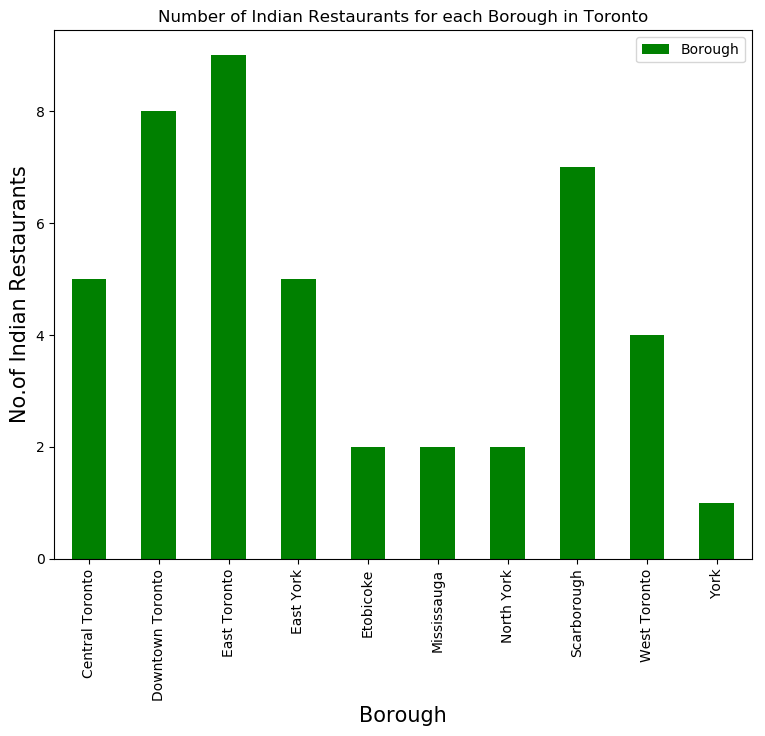

In [20]:
plt.figure(figsize=(9,7), dpi = 100)
# Title
plt.title('Number of Indian Restaurants for each Borough in Toronto')
#x-axis
plt.xlabel('Borough', fontsize = 15)
#y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#Bar Plot
indian_rest_tn.groupby('Borough')['ID'].count().plot(kind='bar', color='g', label='Borough')
#Legend
plt.legend()
#displays the plot
plt.show()